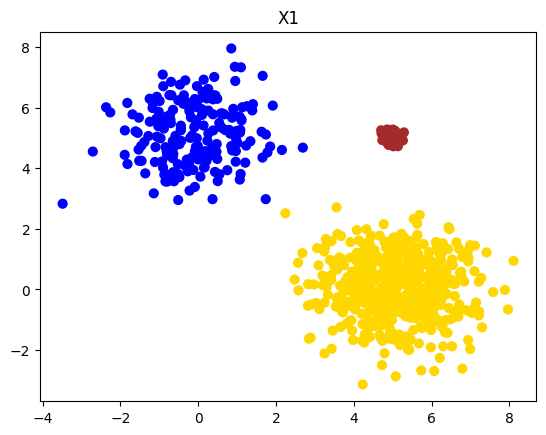

In [88]:
import numpy as np
import matplotlib.pyplot as plt 

ncells = 1000  # Number of cells


xmus = [0, 5, 5]
xsds = [1, 0.1, 1]
ymus = [5, 5, 0]
ysds = [1, 0.1, 1]

prop1 = [0.2, 0.3, 0.5]
comp1 = np.random.choice([1, 2, 3], p=prop1, size=ncells, replace=True)
ref_cols = ["blue", "brown", "gold"]
clust1 = np.array([ref_cols[i-1] for i in comp1])


samples1 = np.column_stack((np.random.normal(loc=np.array(xmus)[comp1-1], scale=np.array(xsds)[comp1-1], size=ncells),
                            np.random.normal(loc=np.array(ymus)[comp1-1], scale=np.array(ysds)[comp1-1], size=ncells)))
ngenes = 100


plt.title('X1')
proj = np.random.normal(size=(ngenes, 2))

X1 = np.dot(samples1, proj.T)

plt.scatter(samples1[:, 0], samples1[:, 1], marker='o', s=40, c=clust1)

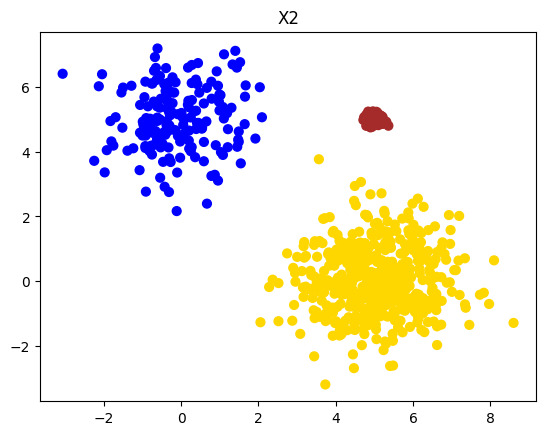

In [89]:
xmus = np.array([0, 5, 5, 0]) 
xsds = [1, 0.1, 1, 1]
ymus = np.array([5, 5, 0, 0]) 
ysds = [1, 0.1, 1, 1]


prop2 = [0.2, 0.3, 0.5]

# Setting proportions of each of the three cell types in batch 2.
comp2 = np.random.choice([1, 2, 3], p=prop2, size=ncells, replace=True)

samples2 = np.column_stack((np.random.normal(loc=np.array(xmus)[comp2-1], scale=np.array(xsds)[comp2-1], size=ncells),
                      np.random.normal(loc=np.array(ymus)[comp2-1], scale=np.array(ysds)[comp2-1], size=ncells)))
ref_cols = ["blue", "brown", "gold",]
clust2 = [ref_cols[i-1] for i in comp2]

plt.scatter(samples2[:, 0], samples2[:, 1], marker='o', s=40, c=clust2)

plt.title('X2')
plt.show()

X2 = np.dot(samples2, proj.T)

#A2 = np.transpose(A2)
row_names = [f"Cell{i+1}-1" for i in range(ncells)]
col_names = [f"Gene{i+1}" for i in range(ngenes)]


In [58]:
from scipy.spatial import cKDTree

def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    k_index_1 = cKDTree(data1).query(x=data2, k=k1, workers=n_jobs)[1]
    k_index_2 = cKDTree(data2).query(x=data1, k=k2, workers=n_jobs)[1]
    mutual_1 = []
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
        for index_1 in k_index_1[index_2]:
            if index_2 in k_index_2[index_1]:
                mutual_1.append(index_1)
                mutual_2.append(index_2)
    return mutual_1, mutual_2

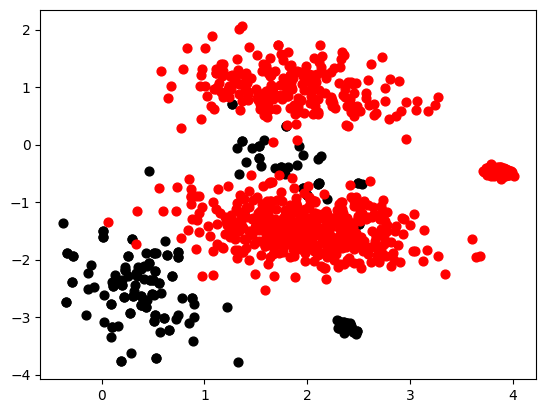

In [65]:
mutual_1, mutual_2 = find_mutual_nn(view1, view2, k1 = 2, k2 = 2, n_jobs=10)

plt.scatter((new_batch_in[mutual_1])[:, 0], (new_batch_in[mutual_1])[:, 1], marker='o', s=40, c='black')
plt.scatter((ref_batch_in)[:, 0], (ref_batch_in)[:, 1], marker='o', s=40, c='red')

In [39]:
import numpy
def total_correlation(X1, X2, k):
    r1 = 1e-4
    r2 = 1e-4

    n1 = X1.shape[1] 
    n2 = X2.shape[1]
    m = X1.shape[0] #number of rows

    mean1 = numpy.mean(X1, axis=0)
    mean2 = numpy.mean(X2, axis=0)

    H1bar = X1 - numpy.tile(mean1, (m, 1))
    H2bar = X2 - numpy.tile(mean2, (m, 1))


    SigmaHat12 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H2bar)
    SigmaHat11 = (1.0 / (m - 1)) * numpy.dot(H1bar.T, H1bar) + r1 * numpy.identity(n1)
    SigmaHat22 = (1.0 / (m - 1)) * numpy.dot(H2bar.T, H2bar) + r2 * numpy.identity(n2)


    [D1, V1] = numpy.linalg.eigh(SigmaHat11) #Eigendecomposition for easy inversion
    [D2, V2] = numpy.linalg.eigh(SigmaHat22) #Eigendecomposition for easy inversion
    SigmaHat11RootInv = numpy.dot(numpy.dot(V1, numpy.diag(D1 ** -0.5)), V1.T) #
    SigmaHat22RootInv = numpy.dot(numpy.dot(V2, numpy.diag(D2 ** -0.5)), V2.T)
    T = numpy.dot(numpy.dot(SigmaHat11RootInv, SigmaHat12), SigmaHat22RootInv)
    

    [U, D, V] = numpy.linalg.svd(T)
    V = V.T
    A1star = numpy.dot(SigmaHat11RootInv, U[:, 0:k])
    A2star = numpy.dot(SigmaHat22RootInv, V[:, 0:k])
    D = D[0:k]

    top_k_singular_values = D[:k]

    total_corr = numpy.sum(D)

    return A1star, total_corr, A2star

In [40]:
A1, total_corr, A2 = total_correlation(X1, X2, k=2)

view1 = X1 @ A1
view2 = X2 @ A2
#view1 = view1 / np.linalg.norm(view1, axis=0, keepdims=True)
#view2 = view2 / np.linalg.norm(view2, axis=0, keepdims=True)


In [41]:
ref_batch_in = view1
new_batch_in = view2

In [90]:
k = 25
n_jobs = 10
mnn_ref, mnn_new = find_mutual_nn(data1=ref_batch_in,
                                  data2=new_batch_in, k1=k, k2=k,  n_jobs=n_jobs)

In [91]:
def l2_norm(in_matrix):
    return np.linalg.norm(x=in_matrix, axis=0)


def scale_rows(in_matrix, scale_vector):
    return np.divide(in_matrix, scale_vector)


In [92]:
a = l2_norm(view1)
b = l2_norm(view2)

In [93]:
view1 = scale_rows(view1, a)
view2 = scale_rows(view2, b)

In [94]:
def kdist(m, n):
    dist = np.zeros((m.shape[0], n.shape[0]), dtype=np.float32)
    for i in range(m.shape[0]):
        for j in range(n.shape[0]):
            dist[i, j] = np.dot(m[i], n[j])
    return dist

In [95]:
import numpy as np

def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    vect = data1[mnn1] - data2[mnn2]
    mnn_index, mnn_count = np.unique(mnn2, return_counts=True)
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
        vect_reduced[index] += ve
    vect_avg = np.divide(vect_reduced[mnn_index], mnn_count.astype(np.float32)[:, None])
    #exp_distance = np.exp(-kdist(data2_or_raw2, data2_or_raw2[mnn_index]) / sigma)
    #density = np.sum(exp_distance[mnn_index], axis=0)
    #mult = np.divide(exp_distance, density)
    #total_prob = np.sum(mult, axis=1, keepdims=True)
    #output = np.dot(mult, vect_avg)

    return vect_avg

In [96]:
sigma = 1
correction_in = compute_correction(ref_batch_in, new_batch_in, mnn_ref, mnn_new,
                                           new_batch_in, sigma)

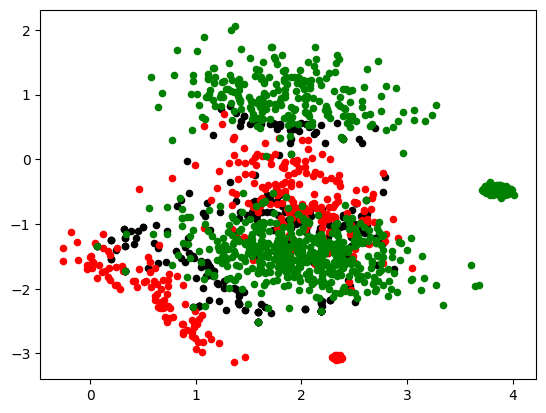

In [104]:
plt.scatter((new_batch_in[np.unique(mnn_new)] + correction_in)[:, 0], (new_batch_in[np.unique(mnn_new)] + correction_in)[:, 1], marker='o', s=20, c='black')
plt.scatter((new_batch_in[np.unique(mnn_new)])[:, 0], (new_batch_in[np.unique(mnn_new)])[:, 1], marker='o', s=20, c='red')
plt.scatter((ref_batch_in)[:, 0], (ref_batch_in)[:, 1], marker='o', s=20, c='green')

In [83]:
mnn_index, mnn_count = np.unique(mnn_ref, return_counts=True)
mnn_count

array([ 5,  2,  6,  2,  1,  3,  1,  1,  2, 21,  1, 24,  6, 19,  3,  1,  8,
        3, 13,  3, 12, 18,  2, 20, 25,  1,  2,  4,  7,  6, 21,  1,  1, 23,
        4, 25,  5,  2,  4,  3, 14, 25,  5,  3, 22,  1,  2, 25, 16, 25,  4,
        5, 18,  4,  3, 25, 20,  1, 12, 14,  6,  2,  2,  5,  1,  3, 14,  2,
       12, 22,  1,  1,  1, 18, 25,  6, 16, 23,  1, 20,  3,  4,  1,  1, 21,
        2,  7,  1,  1,  9,  1,  2,  9,  8, 11, 19,  2,  8,  2,  3,  3, 22,
        6,  2,  3,  1,  2,  6,  1,  3,  1,  2,  5,  3, 25,  1, 14,  6,  2,
        7,  7,  1,  1,  1,  3, 18,  7, 15,  5,  4, 22,  2,  2,  4,  4,  1,
        1,  4, 25, 14, 25, 11, 25,  8, 10,  2,  2,  8,  1, 21,  4,  2,  9,
        5,  4,  3,  1,  1, 13,  2,  1, 23,  9,  1,  4,  4,  2,  8, 18,  2,
       25,  8, 20, 17,  2,  3,  3,  5,  2, 13, 25, 16, 20,  4, 18, 17,  1,
        4, 19, 16,  6,  6,  8,  3, 24,  1,  2,  2, 10, 24, 21,  1, 12,  4,
        3,  2,  4,  9, 17,  1, 21, 16, 17, 11,  1,  2,  2,  7, 10,  3, 17,
        5, 14,  3,  4, 20

In [31]:
import umap

In [32]:
reducer = umap.UMAP()

In [33]:
from sklearn.preprocessing import StandardScaler
scaled_data1 = StandardScaler().fit_transform(new_batch_in + correction_in)
embedding1 = reducer.fit_transform(scaled_data1)

In [19]:
scaled_data2 = StandardScaler().fit_transform(ref_batch_in)
embedding2 = reducer.fit_transform(scaled_data2)

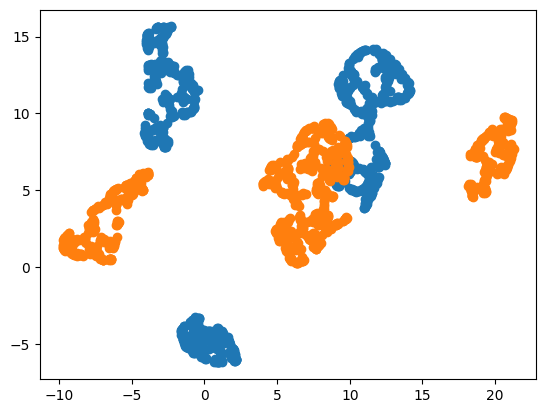

In [20]:
plt.scatter(embedding1[:, 0], embedding1[:, 1])
plt.scatter(embedding2[:, 0], embedding2[:, 1])